In [1]:
!pip install datasets &>> install.log

from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [6]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# Необычная функция активации
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

# Time Embedding
class TimeEmbedding(nn.Module):

    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        # Первый линейный слой
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Активация
        self.act = Swish()
        # Второй линейный слой
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb

class ResidualBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        super().__init__()
        # Групповая нормализация и первый слой свертки
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # Первый слой сверткиr
        h = self.conv1(self.act1(self.norm1(x)))
        # Добавление time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Второй слой свертки
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.shortcut(x)

# attention
class AttentionBlock(nn.Module):

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Слой нормализации
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Линейный слой для окончательного преобразования
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t

        batch_size, n_channels, height, width = x.shape

        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)

        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)

        q, k, v = torch.chunk(qkv, 3, dim=-1)

        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=1)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)


        res += x


        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res


class DownBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()


        n_resolutions = len(ch_mults)


        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))


        self.time_emb = TimeEmbedding(n_channels * 4)


        down = []

        out_channels = in_channels = n_channels

        for i in range(n_resolutions):

            out_channels = in_channels * ch_mults[i]

            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels

            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))


        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Вторая половина U-Net - увеличение разрешения
        up = []

        in_channels = out_channels

        for i in reversed(range(n_resolutions)):

            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))

            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels

            if i > 0:
                up.append(Upsample(in_channels))


        self.up = nn.ModuleList(up)


        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):

        # Получить time-step embeddings
        t = self.time_emb(t)

        x = self.image_proj(x)

        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Получить пропущенное соединение из первой половины U-Net и объединить
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        # Окончательная нормализация и свертка
        return self.final(self.act(self.norm(x)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

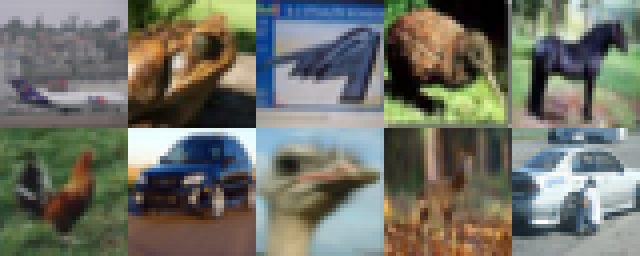

In [2]:
# Скачать и загрузить набор данных
cifar10 = load_dataset('cifar10')

image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

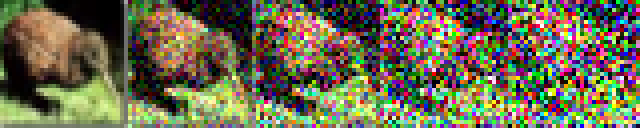

In [3]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
  var = gather(beta, t) # βt
  eps = torch.randn_like(xtm1) # Шум в форме xtm1
  return mean + (var ** 0.5) * eps

# Показать на разных этапах
ims = []
start_im = cifar10['train'][3]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Сохранение изображения каждые 20 шагов, чтобы показать прогресс
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Вычислить Xt с учётом Xt-1 (т.е. x из предыдущей итерации)
  t = torch.tensor(t, dtype=torch.long) # t как тензор
  x = q_xt_xtminus1(x, t) # Изменение x, используя нашу функцию выше

# Отображение изображений
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

In [7]:
x = torch.randn(10, 3, 32, 32)
t = torch.tensor([50.], dtype=torch.long)
unet = UNet()
model_output = unet(x, t)
model_output.shape

# Создайте модель
unet = UNet(n_channels=32).cuda()

# Настройка параметров
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# возвращаем шум
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # также возвращает шум

# Тренировочные параметры
batch_size = 128
lr = 3e-4 # Скорочть обучение, это значение я называю это константой Карпати

losses = [] # Сохранение потери для построения графика

dataset = cifar10['train']
optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Оптимизатор

for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Просмотр набора данных
  ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)]
  tims = [img_to_tensor(im).cuda() for im in ims] # Преобразование в тензоры
  x0 = torch.cat(tims)
  t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
  xt, noise = q_xt_x0(x0, t)
  pred_noise = unet(xt.float(), t)
  loss = F.mse_loss(noise.float(), pred_noise)
  losses.append(loss.item())
  optim.zero_grad()
  loss.backward()
  optim.step()

  0%|          | 0/390 [00:00<?, ?it/s]

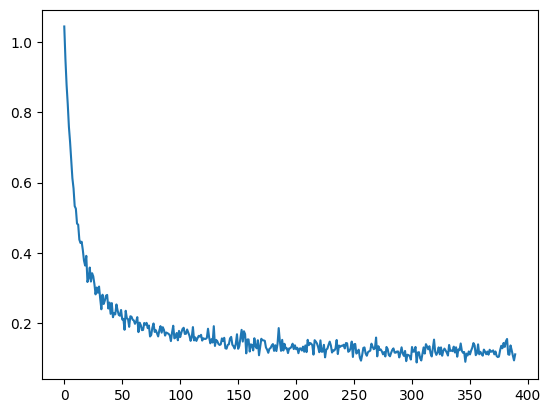

In [8]:
from matplotlib import pyplot as plt
plt.plot(losses)

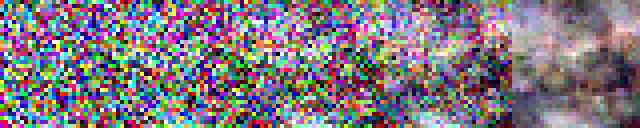

In [9]:
def p_xt(xt, noise, t):
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps

x = torch.randn(1, 3, 32, 32).cuda() # Создадим рандомный шум
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%24 == 0:
      ims.append(tensor_to_image(x.cpu()))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

torch.Size([10, 3, 32, 32])


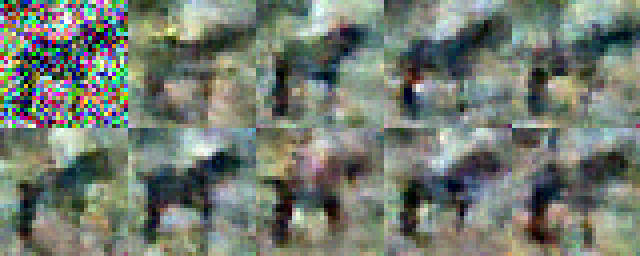

In [10]:
horse = cifar10['train'][4]['img']
x0 = img_to_tensor(horse)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(10)] )
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)
ims = []
for i in range(50, n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
  if i==0:image.paste(tensor_to_image(example_start.unsqueeze(0).cpu()), ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)